# Linear Regression research pipeline: House Pricing

The dataset describes the sale of individual residential properties in Ames, Iowa, United States from 2006 to 2010. The dataset contains 1460 observations and a large number of explanatory variables involved in assessing home values. This dataset gives us a chance to look into the data on what really influences the value of a house.  The "openml.org" is a public data repository for machine learning data and experiments, that allows everybody to upload open datasets.

In [90]:
from sklearn.datasets import fetch_openml
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.tools.eval_measures import rmse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

In [91]:
X, y = fetch_openml("house_prices", version=1, as_frame=True, return_X_y=True)
df = pd.concat([X, y], axis=1)
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,...,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal,208500.0
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,...,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal,181500.0
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,...,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal,223500.0
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,...,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,...,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal,250000.0


<AxesSubplot:>

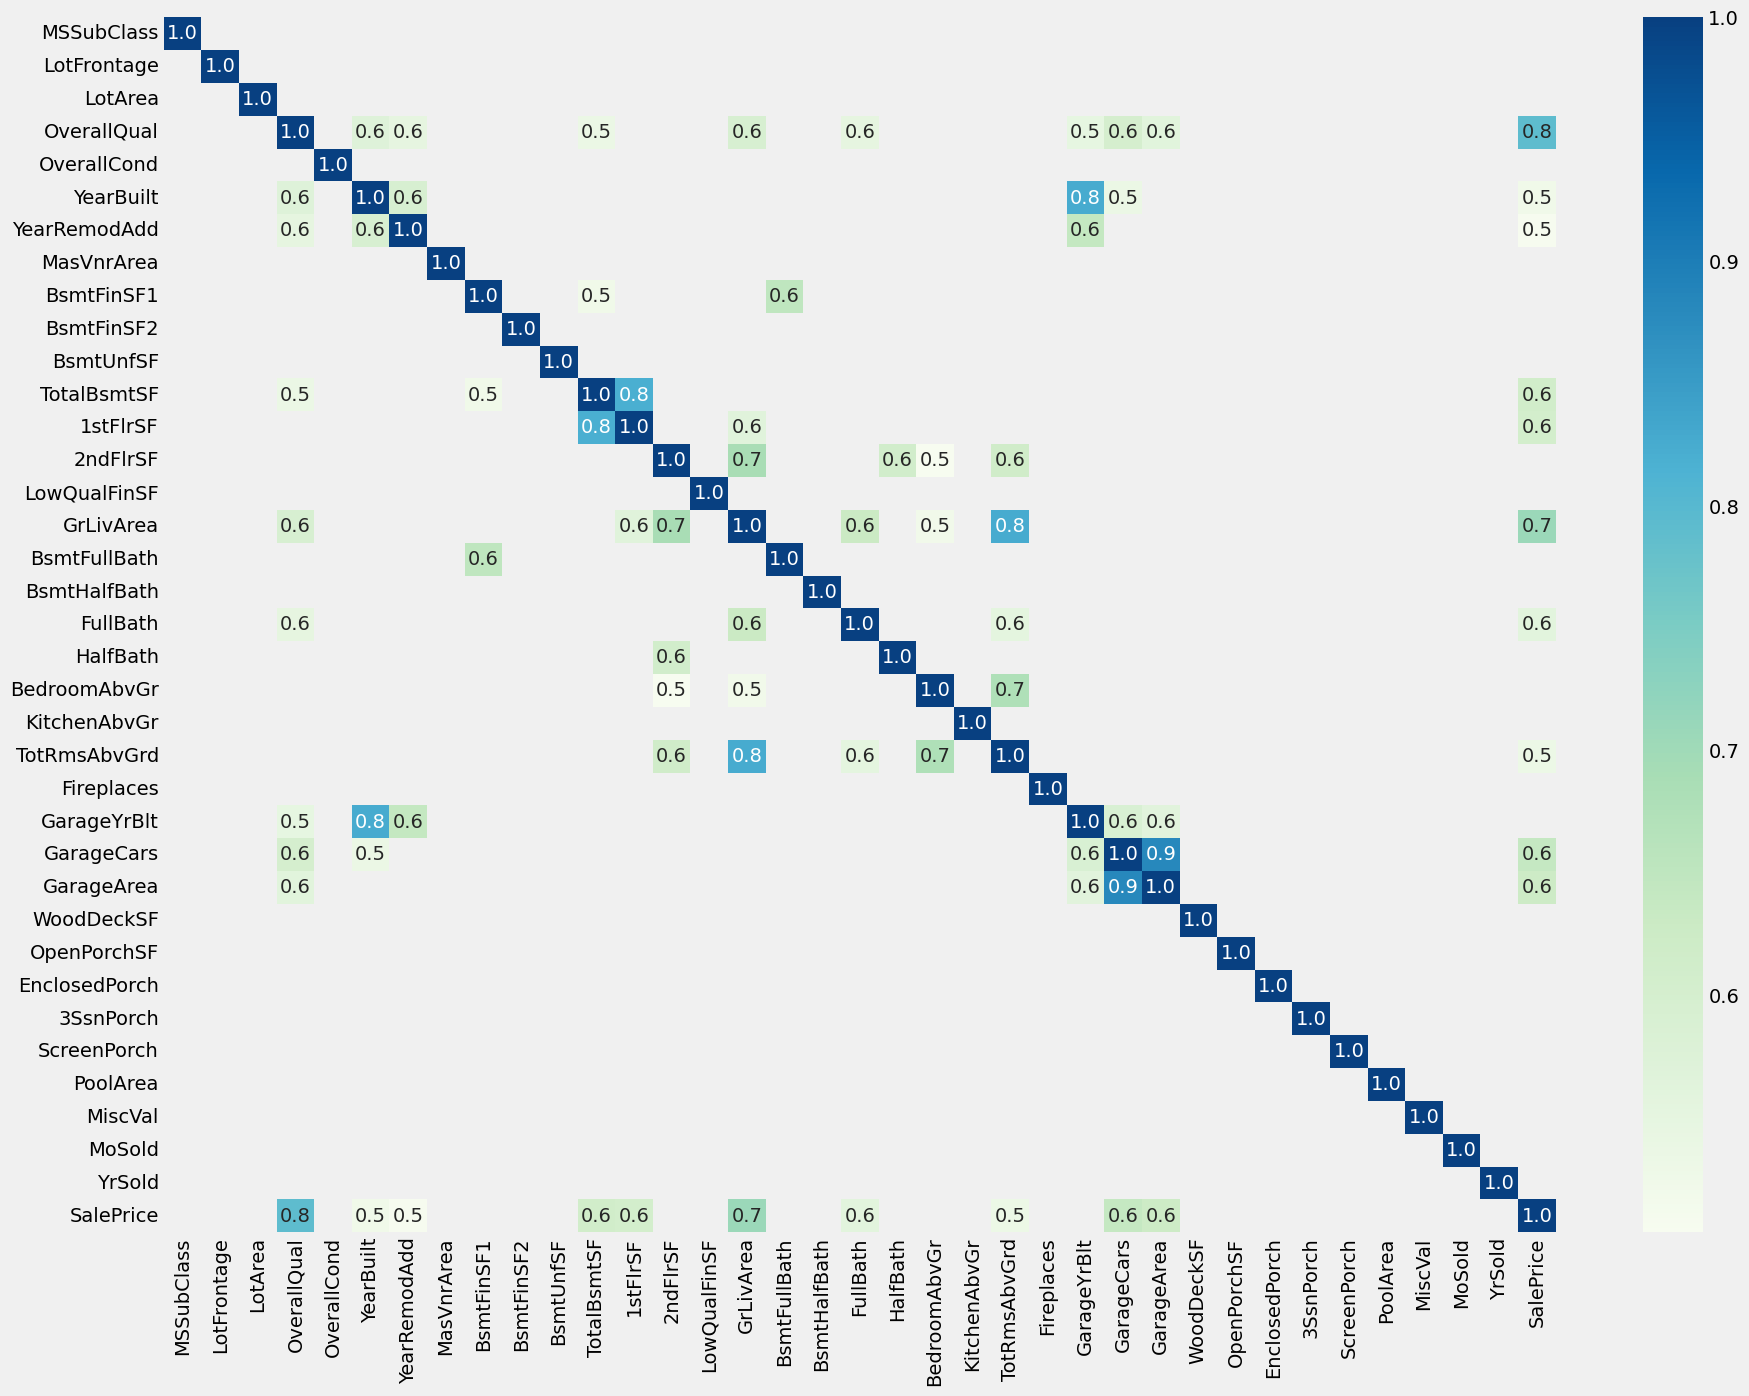

In [93]:
corr_mat = df.drop(columns=['Id']).corr(numeric_only=True)
high_corr_mat = corr_mat[abs(corr_mat) >= 0.5]

# Plot correlation heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(high_corr_mat, annot=True, fmt='.1f', cmap='GnBu')

In [95]:
df_corr = corr_mat[abs(corr_mat) >= 0.5].unstack().rename('values').reset_index()
df_corr.query('values == values & values != 1').sort_values('values', ascending=False).head(10)

,level_0,level_1,values
951,GarageCars,GarageArea,0.882475
987,GarageArea,GarageCars,0.882475
893,GarageYrBlt,YearBuilt,0.825667
209,YearBuilt,GarageYrBlt,0.825667
577,GrLivArea,TotRmsAbvGrd,0.825489
829,TotRmsAbvGrd,GrLivArea,0.825489
419,TotalBsmtSF,1stFlrSF,0.819530
455,1stFlrSF,TotalBsmtSF,0.819530
147,OverallQual,SalePrice,0.790982
1335,SalePrice,OverallQual,0.790982


Heatmap shows that highly positively correlated between independent features. We can check the performance of the model by excluding one of them

## Estimating the relationship between target variable and features

### Univariate: y = α + βx + ε

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -9.621e+04   5756.407    -16.713      0.000   -1.07e+05   -8.49e+04
OverallQual  4.544e+04    920.430     49.364      0.000    4.36e+04    4.72e+04
SalePrice = -96,206.08 + 45,435.80 * OverallQual
R2: 0.625651892462118


Text(0.5, 1.0, 'SalePrice & OverallQual coefficient')

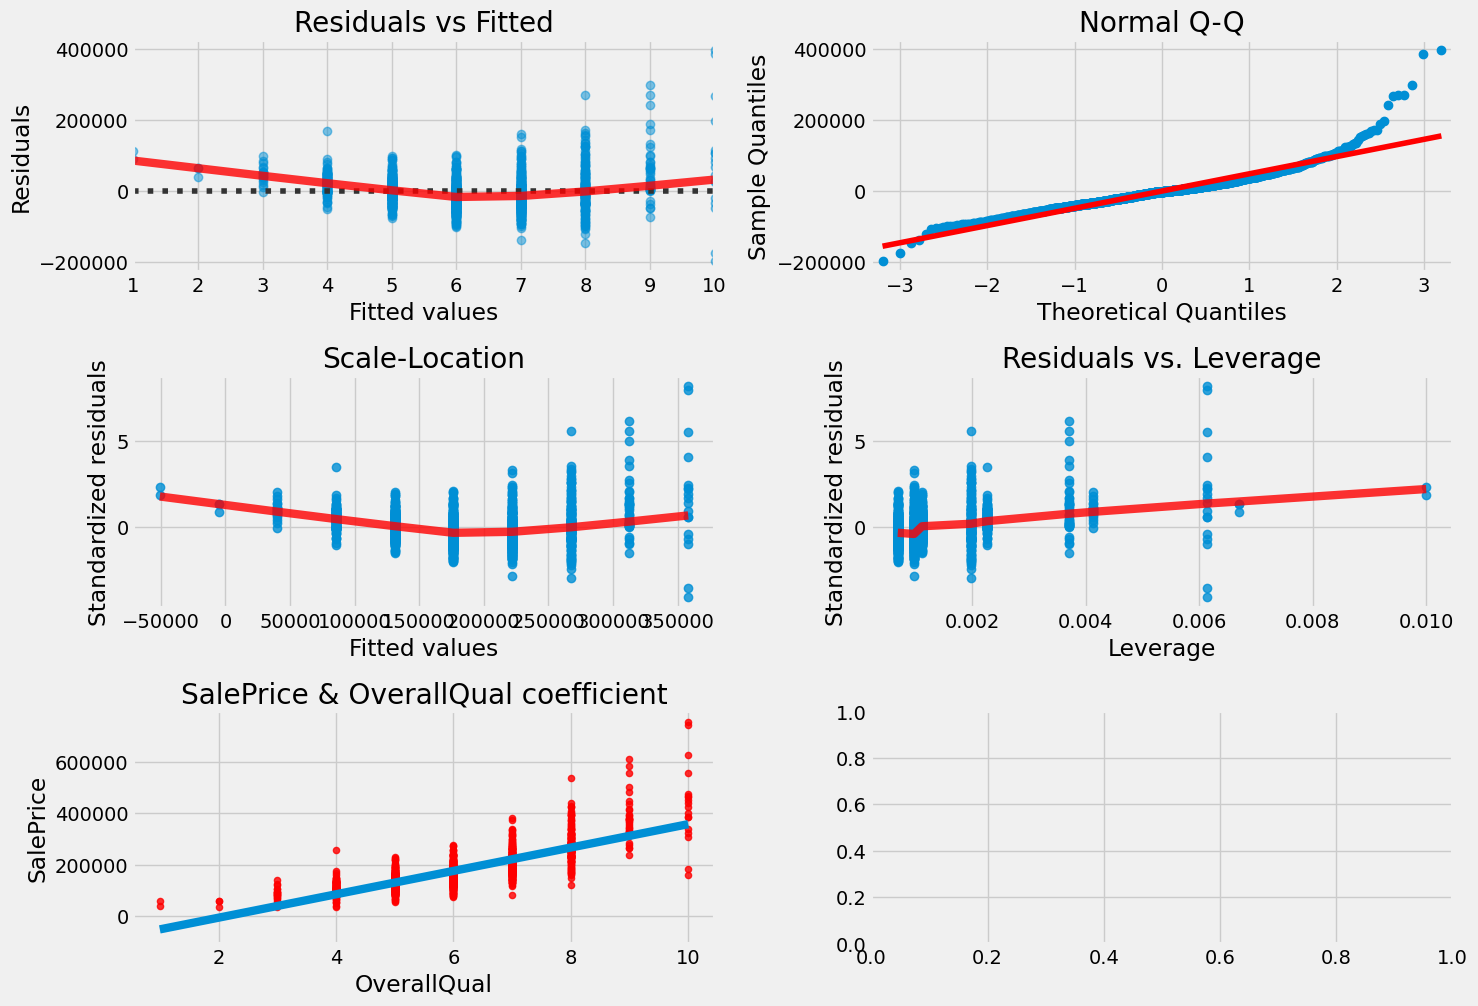

In [8]:
target = 'SalePrice'
var = 'OverallQual'

# coef
linear_model = smf.ols(f'{target} ~ {var}', data=df).fit()
print(linear_model.summary().tables[1])
print(f'{target} = {linear_model.params[0]:,.2f} + {linear_model.params[1]:,.2f} * {var}')
print(f'R2: {linear_model.rsquared}')

# plot
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()
line_kws = {'color': 'red', 'alpha': 0.8}

# 1st assumption: x & y have a linear relationship
sns.residplot(data=df, x=var, y=target, lowess=True, scatter_kws={'alpha': 0.5}, line_kws=line_kws, ax=axes[0])
axes[0].set_title('Residuals vs Fitted')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')

# 2nd assumption: ε is normally distributed
sm.qqplot(linear_model.resid, line='s', ax=axes[1])
axes[1].set_title('Normal Q-Q')

# 3rd assumption: y std does not change according to x
influence = linear_model.get_influence()
y = influence.resid_studentized_internal
sns.regplot(x=linear_model.fittedvalues, y=y, scatter=True, lowess=True, line_kws=line_kws, ax=axes[2])
axes[2].set_title('Scale-Location')
axes[2].set_xlabel('Fitted values')
axes[2].set_ylabel('Standardized residuals')

# 4th assumption: yi and yi-1 are independent
x = influence.hat_matrix_diag
sns.regplot(x=x, y=y, scatter=True, lowess=True, line_kws=line_kws, ax=axes[3])
axes[3].set_title('Residuals vs. Leverage')
axes[3].set_xlabel('Leverage')
axes[3].set_ylabel('Standardized residuals')

fig.tight_layout()

# fit linear
sns.regplot(x=df[var], y=df[target], order=1, scatter_kws={'color': 'r', 's': 20}, ax=axes[4])
axes[4].set_title(f'{target} & {var} coefficient')

- Slope: β = 45,435 means that when `OverallQual` increases in 1 points `SalePrice` will increase 45,435
- R2 = 62.5% means that `SalePrice` is explained 62.5% by `OverallQual`.

** Checking Linear Assumptions:
- 1st: `OverallQual` and `SalePrice` should have a linear relationship. The **Residuals vs Fitted** plot shows if there are any nonlinear patterns in the residuals. If this assumption holds and our data can be fit by a linear model, then we should see a relatively flat line when looking at the residuals vs fitted. Notice the bow-shaped line in red, this is an indicator that we are failing to capture some of the non-linear features of the model.
- 2nd: **The distribution of ε must be normally distributed**. The Normal QQ plot shows if the residuals are normally distributed. A good normal QQ plot has all of the residuals lying on or close to the red line. Looking at the graph above, there are several points that fall far away from the red line. This is indicative of the errors not being normally distributed, in fact our model suffers from “heavy tails”.
- 3rd: The Scale-Location shows if there are any relationships between standardized residuals and fitted values.
- 4th: This chart shows if there are any influential observation.

### Univariate: Category

<AxesSubplot:xlabel='GarageType', ylabel='SalePrice'>

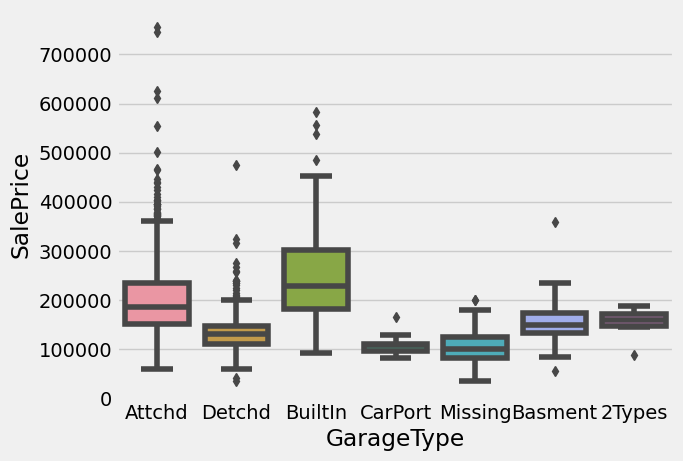

In [5]:
var = 'GarageType'
df[var].fillna('Missing', inplace=True)

sns.boxplot(data=df, x=var, y=target)

It seems that some houses have **BuiltIn** `GarageType` have the higher `SalePrice` than the others. To measure the difference, we run a linear model to check

In [6]:
# coef
linear_model = smf.ols(f'{target} ~ {var}', data=df).fit()
print(linear_model.summary().tables[1])
print(f'R2: {linear_model.rsquared}')

                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.513e+05   2.82e+04      5.372      0.000     9.6e+04    2.07e+05
GarageType[T.Attchd]   5.161e+04   2.83e+04      1.826      0.068   -3819.477    1.07e+05
GarageType[T.Basment]  9287.3509   3.23e+04      0.288      0.774   -5.41e+04    7.27e+04
GarageType[T.BuiltIn]  1.035e+05   2.91e+04      3.555      0.000    4.64e+04    1.61e+05
GarageType[T.CarPort] -4.132e+04   3.64e+04     -1.137      0.256   -1.13e+05       3e+04
GarageType[T.Detchd]  -1.719e+04   2.84e+04     -0.606      0.545   -7.29e+04    3.85e+04
GarageType[T.Missing] -4.797e+04   2.92e+04     -1.644      0.100   -1.05e+05    9281.930
R2: 0.24920423050428975


Based on **P < 0.05**, the result shows that houses built in **BuiltIn** have higher `SalePrice` than **2Types** ~ 103,500. However, the result only show the price difference between **2Types** and others so we need to deep dive more to check others garage types.
Use Tukey method to compare among `GarageType`

In [7]:
mc = MultiComparison(df[target], df[var])
result = mc.tukeyhsd()
df_result = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
df_result.sort_values('p-adj')

,group1,group2,meandiff,p-adj,lower,upper,reject
10,Attchd,Missing,-99575.3724,0.0000,-123233.5860,-75917.1588,True
17,BuiltIn,Missing,-151434.4547,0.0000,-182792.8140,-120076.0954,True
16,BuiltIn,Detchd,-120660.5758,0.0000,-144712.1669,-96608.9848,True
15,BuiltIn,CarPort,-144789.6275,0.0000,-216061.3249,-73517.9302,True
11,Basment,BuiltIn,94181.0544,0.0000,42662.0363,145700.0726,True
9,Attchd,Detchd,-68801.4935,0.0000,-81245.1025,-56357.8846,True
7,Attchd,BuiltIn,51859.0823,0.0000,29077.9337,74640.2310,True
8,Attchd,CarPort,-92930.5452,0.0012,-161165.5745,-24695.5160,True
20,Detchd,Missing,-30773.8788,0.0050,-55657.7968,-5889.9609,True
2,2Types,BuiltIn,103468.4053,0.0071,17539.2009,189397.6098,True


### Univariate: Non-Linear Relationships

Consider in particular the relationship between `OverallQual` and `SalePrice`. It might be a highly non-linear relationship.

`SalePrice` ~ β0 + β1*`OverallQual` + β2*`OverallQual`^2 + ...

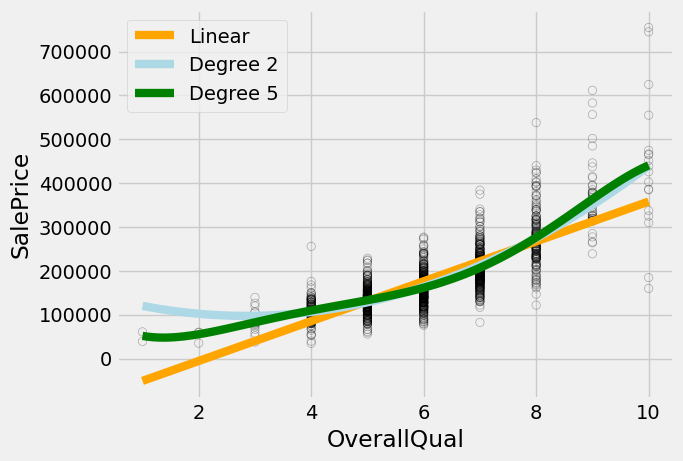

In [13]:
var = 'OverallQual'

fig, ax = plt.subplots(1, 1)

plt.scatter(x=df[var], y=df[target], facecolors='None', edgecolors='k', alpha=.3) 
sns.regplot(x=df[var], y=df[target], ci=None, label='Linear', scatter=False, color='orange')
sns.regplot(x=df[var], y=df[target], ci=None, label='Degree 2', order=2, scatter=False, color='lightblue')
sns.regplot(x=df[var], y=df[target], ci=None, label='Degree 5', order=5, scatter=False, color='g')
plt.legend()

In [25]:
est = sm.OLS.from_formula('SalePrice ~ OverallQual', df).fit()
print(f'R2: {est.rsquared}')
est.summary().tables[1]

R2: 0.625651892462118


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-9.621e+04,5756.407,-16.713,0.000,-1.07e+05,-8.49e+04
OverallQual,4.544e+04,920.430,49.364,0.000,4.36e+04,4.72e+04


In [24]:
df['OverallQual2'] = df['OverallQual'] ** 2
est = sm.OLS.from_formula('SalePrice ~ OverallQual + OverallQual2', df).fit()
print(f'R2: {est.rsquared}')
est.summary().tables[1]

R2: 0.6784507354727529


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.516e+05,1.69e+04,8.978,0.000,1.18e+05,1.85e+05
OverallQual,-3.801e+04,5461.783,-6.959,0.000,-4.87e+04,-2.73e+04
OverallQual2,6676.3161,431.637,15.467,0.000,5829.620,7523.012


The Quadratic model has R2 0.67 > 0.62 baseline model

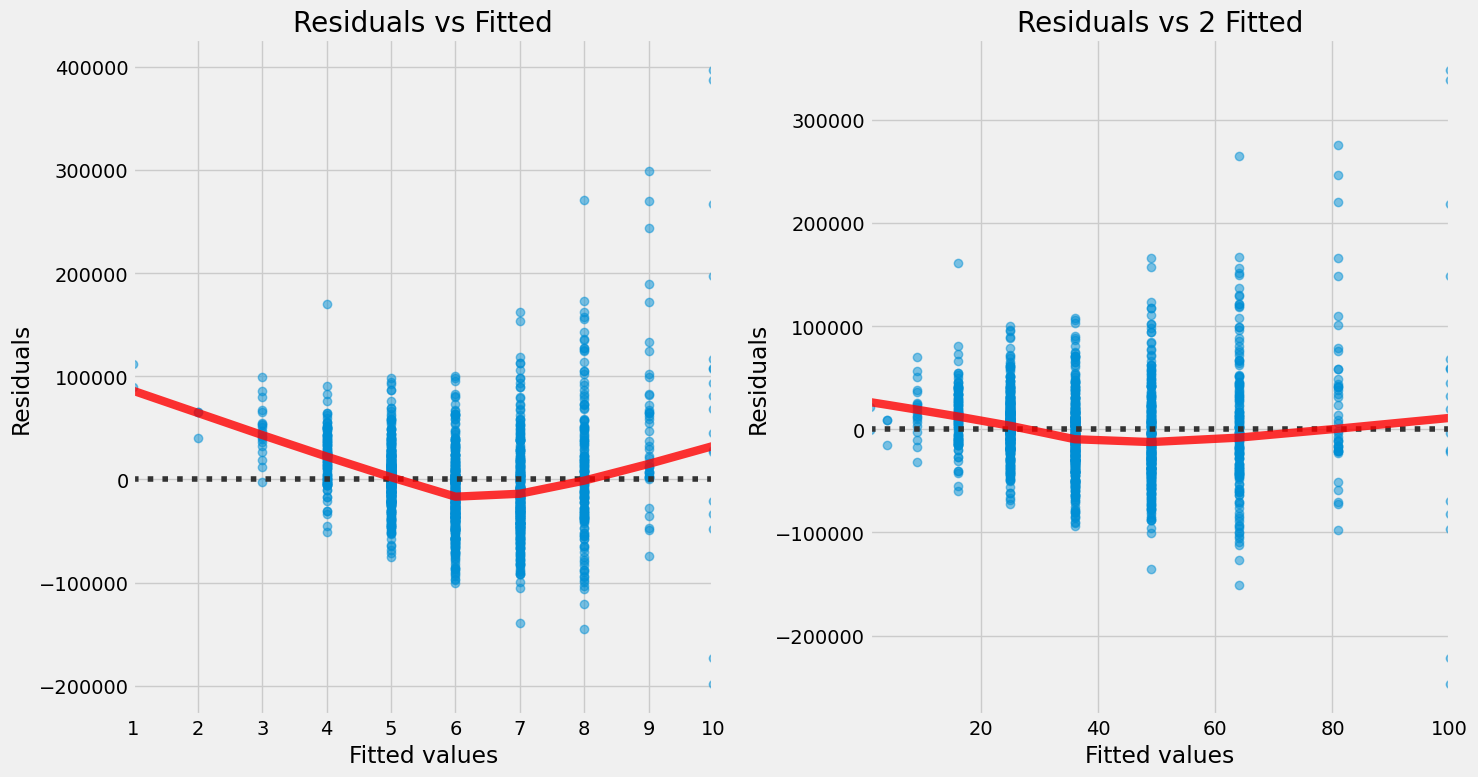

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes = axes.flatten()
line_kws = {'color': 'red', 'alpha': 0.8}

sns.residplot(data=df, x='OverallQual', y=target, lowess=True, scatter_kws={'alpha': 0.5}, line_kws=line_kws, ax=axes[0])
axes[0].set_title('Residuals vs Fitted')
sns.residplot(data=df, x='OverallQual2', y=target, lowess=True, scatter_kws={'alpha': 0.5}, line_kws=line_kws, ax=axes[1])
axes[1].set_title('Residuals vs Quadratic Fitted')
for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')
fig.tight_layout()

This suggests a quadratic fit, the residuals `OverallQual2` seem more uniformly centered around zero.

### Multivariate

The basic idea of hedonic price modeling is that neighborhood-specific and unit-specific characteristics help determine house prices. If target variable is the sale price, then naturally the larger the house the higher the price, all else being equal. So property size measures will be key variables.

Any home buyer would have heard of the expression “location, location, location”, so one would expect neighborhood “location” and associated characteristics, such as access to amenities (e.g. good schools, leisure facilities), transport networks (e.g. near a metro station), neighborhood aesthetics (e.g. tree-lined streets, handsome houses), and socioeconomic prestige among others, to have an impact on house prices.

The factors that effect housing prices may be summarized as property size, location desirability, nearby amenities, number of rooms, construction materials, and age and condition of the structure.

**Looking at size metrics**

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

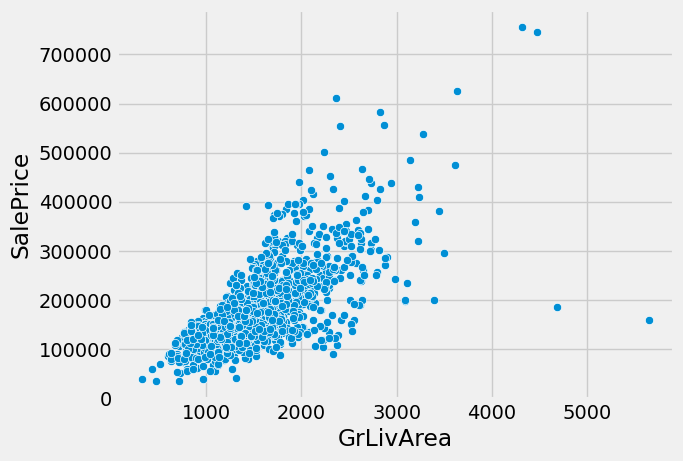

In [33]:
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice')

It seems that `GrLivArea` increases then `SalePrice` increases. However, we don't know wether the increase is random or bias. We start to check with linear regression

#### Model 1: GrLivArea

In [54]:
def run_model(var, target, data):
    text = ' + '.join(var)
    est = sm.OLS.from_formula(f'{target} ~ {text}', data).fit()
    rmse_score = rmse(data[target], est.predict(data[var]))
    print(f'R2: {est.rsquared}')
    print(f'RMSE: {rmse_score}')
    print(est.summary().tables[1])

In [55]:
var = ['GrLivArea']
run_model(var, target, df)

R2: 0.5021486502718042
RMSE: 56034.303865279944
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.857e+04   4480.755      4.144      0.000    9779.612    2.74e+04
GrLivArea    107.1304      2.794     38.348      0.000     101.650     112.610


In [57]:
var = ['GrLivArea', 'GarageArea']
run_model(var, target, df)

R2: 0.6107742041987958
RMSE: 49545.58311376032
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6915.3807   4159.871     -1.662      0.097   -1.51e+04    1244.594
GrLivArea     80.6713      2.798     28.834      0.000      75.183      86.159
GarageArea   138.6572      6.876     20.165      0.000     125.169     152.146


In [45]:
# size metrics
var = ['GrLivArea', 'LotArea', 'GarageArea']
text = ' + '.join(var)
est = sm.OLS.from_formula(f'{target} ~ {text}', df).fit()

In [48]:
rmse(df[target], est.predict(df[var]))

49328.76944867221

In [31]:
est.summary().tables[0]

Dep. Variable:,SalePrice,R-squared:,0.614
Model:,OLS,Adj. R-squared:,0.613
Method:,Least Squares,F-statistic:,772.6
Date:,"Sun, 11 Dec 2022",Prob (F-statistic):,1.87e-300
Time:,08:14:44,Log-Likelihood:,-17849.
No. Observations:,1460,AIC:,3.571e+04
Df Residuals:,1456,BIC:,3.573e+04
Df Model:,3,,
Covariance Type:,nonrobust,,


How to check whether the model fit well the data with multiple regressors?
- The F-test tries to answer the question “Is There a Relationship Between the Response and Predictors?”
- In particular, it tests the following hypothesis:H1: is at least one coefficient different from zero? against the null hypothesis H0: β0 = β1 = … = 0. This hypothesis test is performed by computing the F-statistic: F = ((TSS - RSS) / p) / (RSS / (n - p - 1)). A rule of thumb is to reject H0 if F > 10.